# Analysis of IMDb Movie Metadata

Everyone must have asked a question: What should I watch tonight? <br>
A lot of people try to explore movies from IMDb, potentialy the IMDb's list of "top rated" movies.<br>
However, there are some questions we may need to answer in order to make sense of the IMDb scores: Are the movie scores really informative? What do they mean? What results in the difference in the scores?

In this project, we intend to explore the variables that may be related to the movie scores to give people insights into understanding the IMDb movie scores.

## Data Collection
We scraped the IMDb website for movie metadata. We started from the advance search result page so we would only get results from a specific time range and valid number of ratings. 
The raw metadata looks like this: 
![alt webpage](https://i.imgur.com/LnntOMw.png)



In order to obtain the data, we used 2 libraries. First we get the webpages in HTML using requests. Secondly we used beautiful soup to parse the HTML and retrieved the features. For the features, we decided to encode genre as 1s and 0s using one-hot encoding which will facilitate our further investigation.


In [1]:
import requests, re
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
GENRES = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 
'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

the function that parses a single HTML page

In [2]:
def parse_page(html, df):
    def parse_votes(resultSet):
        try:
            nvs = resultSet[0].find_all("span", {"name" :"nv"})
            if (len(nvs) == 1):
                return (int(nvs[0].text.replace(",", "")), np.nan)
            return (int(nvs[0].text.replace(",", "")), nvs[1].text)
        except: 
            return (0,0)
    
    soup = BeautifulSoup(html, 'html.parser')
    # make a list of movies
    listerlist = soup.find_all('div', class_ = "lister-item mode-advanced")
    
    # get all the titles
    imgList = [movieItem.find('img') for movieItem in listerlist]
    nameList = [imgItem["alt"] for imgItem in imgList]
    
    # get all the ratings
    ratingsRaw = [movieItem.find("strong") for movieItem in listerlist]
    ratings = [float(rawRating.text) for rawRating in ratingsRaw]

    # get the number of votes. Due to the weird HTML structure, the gross and vote are listed together so it needs to be parsed
    voteNumRaw = [movieItem.find_all("p", class_="sort-num_votes-visible") for movieItem in listerlist]
    votes = [parse_votes(raw) for raw in voteNumRaw]

    # get the year of release
    yearsRaw = [movieItem.find("span", class_ = "lister-item-year text-muted unbold") for movieItem in listerlist]
    years = [int(re.findall("\d{4}", rawYear.text)[0]) for rawYear in yearsRaw]

    # get the list of genres of a film
    genresRaw = [movieItem.find("span", class_ = "genre") for movieItem in listerlist]
    genres = [(list(map(lambda x: x.strip(), rawGenre.text.split(","))) if (rawGenre !=None) else []) for rawGenre in genresRaw]
    
    # get the summaries. Sometimes there is some exception due to the ill-formatted HTML
    try:
        summaryRaw = [movieItem.find_all("p", class_="text-muted") for movieItem in listerlist]
        summaries = [raw[1].text.strip() for raw in summaryRaw]
    except:
        summaries = [""] * len(nameList)

    # insert a film as a column to the overall data frame
    for i in range(len(nameList)):  
        info = dict()
        info["Name"] = nameList[i]
        info["Rating"] = ratings[i]
        info["Year"] =  years[i]
        info["Votes"] = votes[i][0]
        info["Gross"] = votes[i][1]
        info["Summary"] = summaries[i]

        for GENRE in GENRES:
            info["Genre_" + GENRE] = (int(GENRE in genres[i]))
        df = df.append(info, ignore_index=True)
    
    # retrieve the link to the next 250 movies
    nextRaw = soup.select("a.lister-page-next.next-page")
    nextURL = nextRaw[0]["href"] if (len(nextRaw) > 0) else None
    if (nextURL != None):
        nextURL = "http://www.imdb.com/search/title"+nextURL
    return(df, nextURL)

below is an example of a processed webpage.

In [3]:
d = pd.DataFrame(columns=['Name', "Rating", "Year", "Votes", "Gross", "Summary",
                            "Genre_Action", "Genre_Adventure", "Genre_Animation",
                            "Genre_Biography", "Genre_Comedy", "Genre_Crime", 
                            "Genre_Documentary", "Genre_Drama", "Genre_Family",
                            "Genre_Fantasy", "Genre_Film-Noir", "Genre_Game-Show",
                            "Genre_History", "Genre_Horror", "Genre_Music",
                            "Genre_Musical", "Genre_Mystery", "Genre_News", 
                            "Genre_Reality-TV", "Genre_Romance", "Genre_Sci-Fi",
                            "Genre_Sport", "Genre_Talk-Show", "Genre_Thriller",
                            "Genre_War", "Genre_Western"])
# demo & debug
html = requests.get("https://www.imdb.com/search/title?title_type=feature&release_date=2014-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc").text
(df, link) = (parse_page(html, d))
print(link)
df.head()

http://www.imdb.com/search/title?title_type=feature&release_date=2014-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc&page=2&ref_=adv_nxt


,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Mystery,Genre_News,Genre_Reality-TV,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Talk-Show,Genre_Thriller,Genre_War,Genre_Western
0,Paranormal Activity: The Marked Ones,5.0,2014,35349,$32.46M,When a young man becomes the target of a malev...,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Layla Live or Die,5.8,2014,17,NaN,A Middle Eastern girl comes to America to for ...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Percentage,6.1,2014,1937,NaN,"In Miami, two hustlers on the run set up a cre...",1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Grace of God,5.7,2014,20,NaN,"Having lost his faith many years ago, Detectiv...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Let's Ruin It with Babies,5.5,2014,212,NaN,"Channing has it all- a beautiful house, a rock...",0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Then we chained the processing together using a wrapper that retrieves all the movies.
During this process, we observed that there is a weird behavior of IMDb. It only gives us 10,000 films after a query from advanced search. So we separated our calls into 3 to get the data.

In [4]:
# the function that get the html text all related to one link.
def parseAllAfter1950(url, fileName):
    df = pd.DataFrame(columns=['Name', "Rating", "Year", "Votes", "Gross", "Summary",
                            "Genre_Action", "Genre_Adventure", "Genre_Animation",
                            "Genre_Biography", "Genre_Comedy", "Genre_Crime", 
                            "Genre_Documentary", "Genre_Drama", "Genre_Family",
                            "Genre_Fantasy", "Genre_Film-Noir", "Genre_Game-Show",
                            "Genre_History", "Genre_Horror", "Genre_Music",
                            "Genre_Musical", "Genre_Mystery", "Genre_News", 
                            "Genre_Reality-TV", "Genre_Romance", "Genre_Sci-Fi",
                            "Genre_Sport", "Genre_Talk-Show", "Genre_Thriller",
                            "Genre_War", "Genre_Western"])
    while(url):
        html = requests.get(url).text
        try:
            (df, url) = parse_page(html, df)
        except:
            print(url)
        sleep(0.2)
    # save to a pickle for future use
    df.to_pickle(fileName)
    
# link = "http://www.imdb.com/search/title?title_type=feature&release_date=1950-01-01,&num_votes=1,&countries=us&sort=release_date,asc"
# link2 = "http://www.imdb.com/search/title?title_type=feature&release_date=1985-10-04,&num_votes=1,&countries=us&sort=release_date,asc"
# link3 = "http://www.imdb.com/search/title?title_type=feature&release_date=2001-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc"

After scraping, we concatenated the dataframes together to get a complete data set.

In [5]:
df1 = pd.read_pickle("mov-1.pkl")
df2 = pd.read_pickle("mov-2.pkl")
df3 = pd.read_pickle("mov-3.pkl")
movie_df = pd.concat([df1,df2, df3]).drop_duplicates().reset_index(drop=True)
movie_df = movie_df[movie_df[movie_df.columns[6:]].sum(axis = 1) != 0]
movie_df = movie_df[movie_df['Year'] <= 2010]
movie_df.head()

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Mystery,Genre_News,Genre_Reality-TV,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Talk-Show,Genre_Thriller,Genre_War,Genre_Western
0,The Flying Saucer,3.8,1950,301,NaN,Both the CIA and KGB investigate UFOs in Alask...,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,The File on Thelma Jordon,7.0,1950,1523,NaN,Assistant district attorney Cleve Marshall fal...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Traveling Saleswoman,6.3,1950,25,NaN,"In this western comedy, the King Soap Company ...",1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Davy Crockett, Indian Scout",5.5,1950,191,NaN,"Davy Crockett (not the famous Alamo hero, but ...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Cry Murder,5.8,1950,6,NaN,A young actress has retired from films to marr...,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Then we observed that some genres only have very few movie instances. This is problematic for our future processing so we removed those genres.

In [6]:
#remove genres
generes = movie_df.columns[6:]
genre_count = movie_df.iloc[:,6:].sum()
genres_to_remove= movie_df.iloc[:,6:].columns[(genre_count < 200)]
try:
    movie_df = movie_df.drop(genres_to_remove, axis = 1)
except:
    pass

The last step we did to the data frame is to process the gross column (which was text in the format "$1.5M" into numbers that can be used.

In [7]:
def parse_gross(s):    
    try:
        if (s[-1]=="M"):
            return (float(s[1:-1]))
    except:
        return np.nan    
movie_df["Gross"] = movie_df["Gross"].apply(parse_gross)

By now, we have gotten a movie_df data frame that contains all the information we may use to analyze.

In [8]:
movie_df.head()

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western
0,The Flying Saucer,3.8,1950,301,NaN,Both the CIA and KGB investigate UFOs in Alask...,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,The File on Thelma Jordon,7.0,1950,1523,NaN,Assistant district attorney Cleve Marshall fal...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Traveling Saleswoman,6.3,1950,25,NaN,"In this western comedy, the King Soap Company ...",1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,"Davy Crockett, Indian Scout",5.5,1950,191,NaN,"Davy Crockett (not the famous Alamo hero, but ...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Cry Murder,5.8,1950,6,NaN,A young actress has retired from films to marr...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
# imports
import matplotlib.pyplot as plt
import matplotlib
from collections import deque

## Popularity calculation

In [10]:
def get_values(df):
    v = []
    R = []
    for genre in df.columns[6:-1]:
        v1 = sum(df[df[genre] == 1]['Votes'])
        r1 = np.mean(df[df[genre] == 1]['Rating'])
        R.append(r1)
        v.append(v1)
    m = np.mean(df['Votes'])
    C = np.mean(df['Rating'])
    return np.asarray(R), np.asarray(v), m, C
def true_bayesian_estimate(df):
    R, v, m, C = get_values(df)
    return (v/(v+m))*R + (m/(v+m))*C
def true_bayesian_estimate_1(df):
    R = df["Rating"]
    v = df["Votes"]
    m = v.quantile([.25, .5, .75])[0.25]
    C = (R).mean()
    return (v/(v+m))*R + (m/(v+m))*C

In [11]:
ps = true_bayesian_estimate_1(movie_df)
ps = np.nan_to_num(ps)
movie_df = movie_df.assign(Score = pd.Series(ps).values.astype("float"))


In [12]:
# split the data into years
dfs = []
years = list(range(1950, 2000, 10))
for start in range(1950, 2010, 10):
    dfs.append(movie_df[np.logical_and(movie_df['Year'] >= start, movie_df['Year'] < (start + 10))])
movie_df[10000:]

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western,Score
10264,The American Way,5.8,1986,401,NaN,A group of Vietnam vets disturbs television pr...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.800068
10265,Top Gun,6.9,1986,245084,179.80,As students at the United States Navy's elite ...,1,0,0,0,...,0,0,0,1,0,0,0,0,0,6.899789
10266,Nightmare Weekend,2.9,1986,456,NaN,A female scientist performs experiments on thr...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3.171035
10267,Max mon amour,6.1,1986,772,NaN,A married French woman takes a zoo chimp named...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.082821
10268,Playing for Keeps,4.0,1986,543,2.67,"Danny, Spikes and Silk have just recently grad...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.143441
10269,Monster in the Closet,4.9,1986,2031,NaN,After several people and a dog are found dead ...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4.920371
10270,Shadow Play,5.4,1986,71,NaN,A playwright who's staying with the mother of ...,0,0,0,0,...,0,0,1,0,0,0,0,0,0,5.559580
10271,The Last of Philip Banter,5.2,1986,35,NaN,An alcoholic partier becomes a paranoid maniac...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.544274
10272,Down by Law,7.8,1986,40942,1.44,Two innocent people are arrested. An interesti...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.797707
10273,Class of Nuke 'Em High,5.7,1986,6751,NaN,The pupils at a high school next to a nuclear ...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.700696


### is the rating normal distributed?

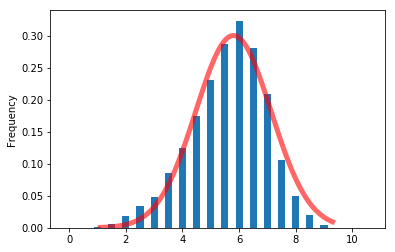

In [13]:
from scipy.stats import norm

r = movie_df['Rating']
r.plot(kind='hist',histtype = 'bar', align = "left",rwidth = 0.5,bins=[i*0.5 for i in range(23)], normed = True)
x = np.linspace(r.min(), r.max(), r.shape[0])
rv = norm(loc = np.mean(r), scale = np.std(r))
plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


From the dirstribution of the ratings. We found the ratings centered around 6

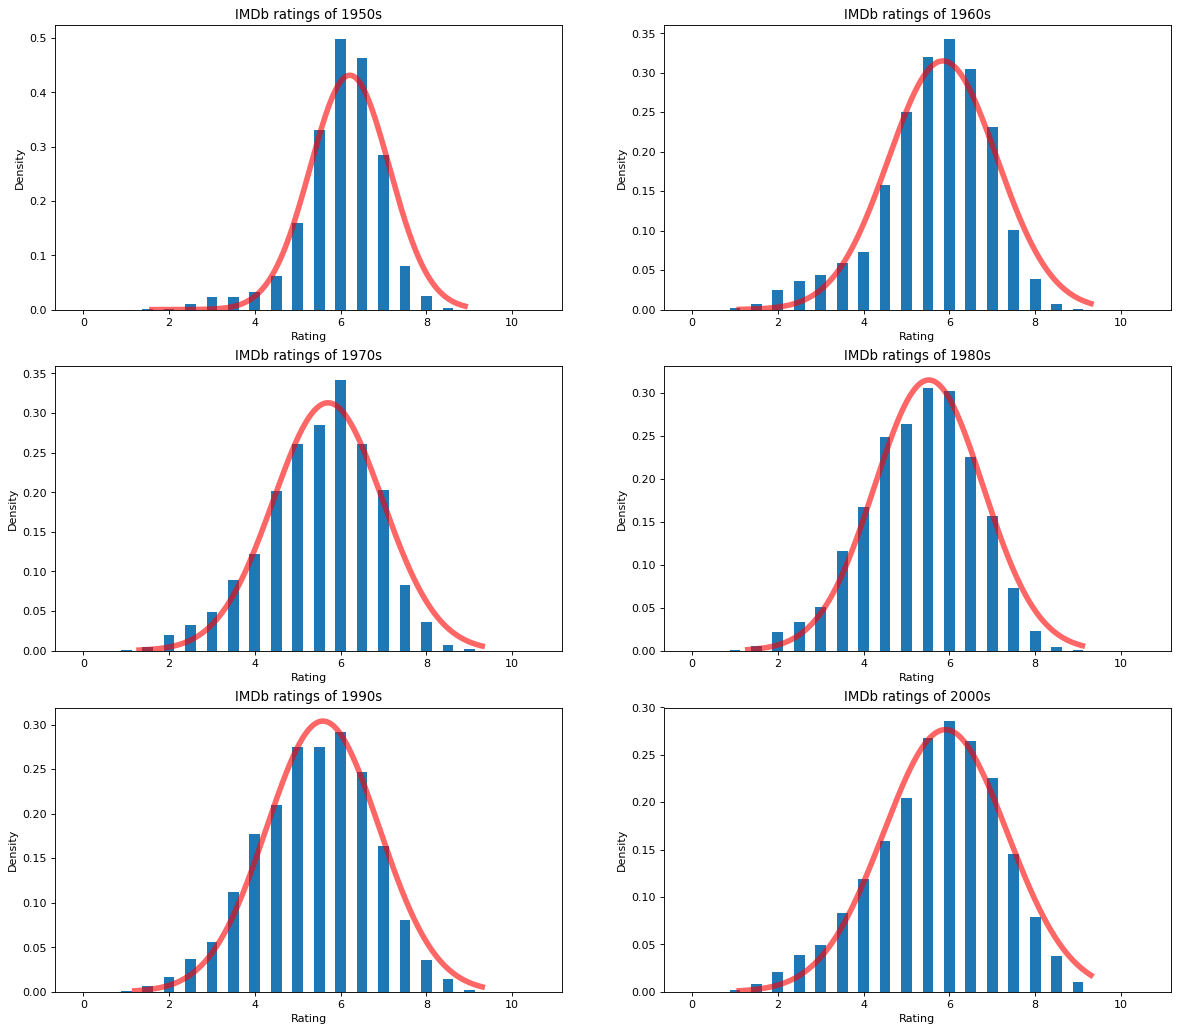

In [14]:
i = 0
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for col in dfs:
    ax = plt.subplot2grid((3,2), (i//2, i%2))
    i = i + 1
    r = col['Rating']
    ax.hist(r, histtype = 'bar', align = "left",rwidth = 0.5,bins=[i*0.5 for i in range(23)], normed=True)
    plt.xlabel("Rating")
    plt.ylabel("Density")
    plt.title("IMDb ratings of "+ str(1940+i*10)+"s")
    x = np.linspace(r.min(), r.max(), r.shape[0])

    rv = norm(loc = np.mean(r), scale = np.std(r))
    ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:
weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
Where:
 - R = average rating for across movie = (Rating)
 - v = number of votes for across movie = (votes)
 - m = a good number of votes to rely on the rating based on votes (m as the average number of votes)
 - C = the mean ratings of all movies

## How popularity varies across genres

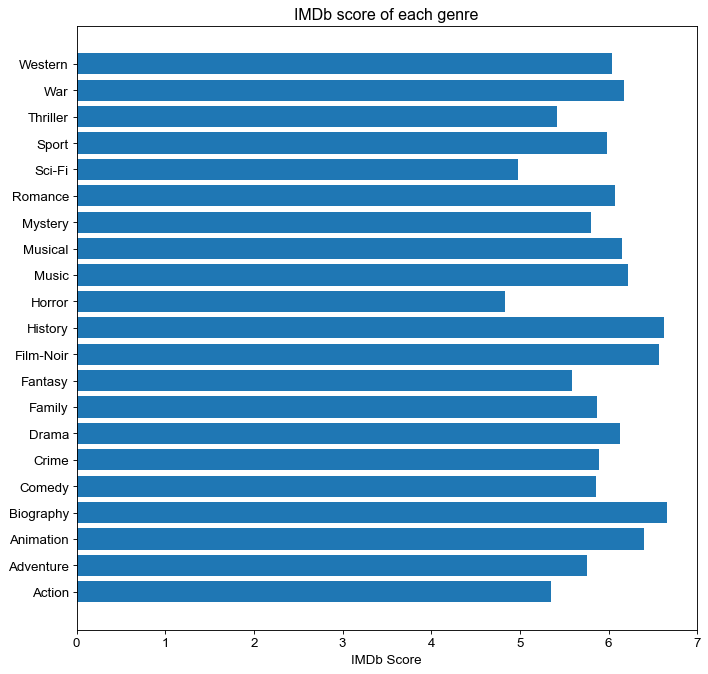

In [15]:
y = true_bayesian_estimate(movie_df)
font = {'family' : 'Arial',
        'size'   : 12}
matplotlib.rc('font', **font)
labels = list(movie_df.columns[6:-1])
labels = [x.replace('Genre_','') for x in labels]
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
y = np.nan_to_num(y)
plt.barh(labels, y)
plt.xlabel('IMDb Score')
plt.title("IMDb score of each genre")
plt.show()
plt.savefig('scorevsgenre.png')

In [16]:
indx = (-y).argsort()[:4]
top_genres = [labels[i] for i in indx ]
top_genres

['Biography', 'History', 'Film-Noir', 'Animation']

In [17]:
import scipy.stats as st

for i in range(len(top_genres)):
    a = movie_df[movie_df[''.join(['Genre_' ,top_genres[i]])] == 1]["Score"]
    b = movie_df[movie_df[''.join(['Genre_' ,top_genres[i]])] == 0]["Score"]
    ## Cross Checking with the internal scipy function
    t2, p2 = st.ttest_ind(a,b)
#     print("t = " + str(t2))
    print(top_genres[i] + " p-value: " + str(p2))
#     print("p = " + str(p2))

Biography p-value: 1.211337525941477e-100
History p-value: 9.992623594019654e-55
Film-Noir p-value: 4.301388884286685e-46
Animation p-value: 4.358555890585483e-33


Hypothesis testing From the hypothesis testing, for each genre in the top genres, it has the popularity larger than the other genres.

TODO: Reformat and explanation

# EDITED
Since we have those assumptions we validated above, it is possible to get a clearer idea of top genres over the decades. We plotted a heatmap to view the average ratings of a genre in all decades.
The horizontal axis is the movie genre, the vertical axis is the decades and lighter cells indicate higher average scores.

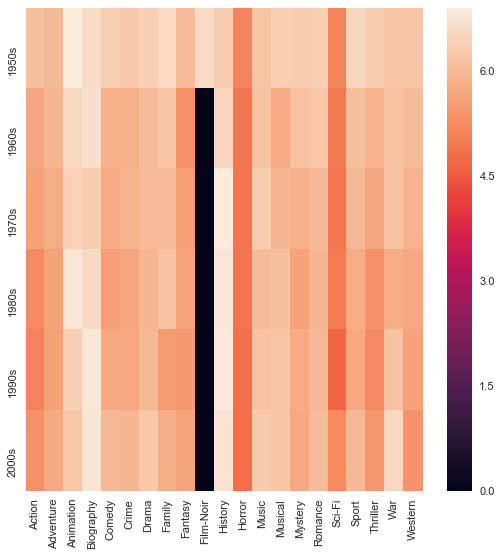

In [18]:
import seaborn as sns; sns.set()
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')

all_years = pd.DataFrame(columns = [ col.split("_")[1] for col in movie_df.columns[6:-1]])
for i in range(6):
    df = dfs[i]
    y = true_bayesian_estimate(df)
    y = np.nan_to_num(y)
    all_years.loc[i] = y
all_years.index = [str(start)+"s" for start in range(1950, 2010, 10)]
ax = sns.heatmap(all_years)

From the plot we can observe that the "Film-Noir" column looks very abnormal. Therefore we further explored the reason why a lot of values about "Film-Noir" is missing. We searched the wikipedia entry of [Film-Noir](https://en.wikipedia.org/wiki/Film_noir)
>Film noir (/fɪlm nwɑːr/; French pronunciation: ​[film nwaʁ]) is a cinematic term used primarily to describe stylish Hollywood crime dramas, particularly those which emphasize cynical attitudes and sexual motivations. Hollywood's classical film noir period is generally regarded as extending from the early 1940s to the late 1950s. 

Voila! We see that this genre of film only last to late 1950s, and that explains why the values are missing.
To better understand the trends of the other genres, we plotted a new heatmap with that genre excluded.

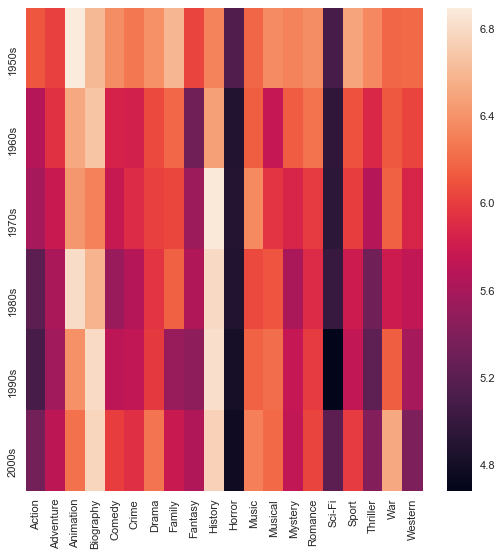

In [19]:
fig=plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
all_years_without_fn = all_years.drop(["Film-Noir"], axis = 1)
ax = sns.heatmap(all_years_without_fn)

From the plot above we can see that there are certain trends. Action, western movies are becoming more and more poorly rated and the Biography and History categories are becoming more and more highly-rated. It also shows us that horror films and Sci-Fi films have poor ratings almost in all decades.


# END

# EDITED
## Release Years

The plots above also shows that the year is probably related to the scores. So we made a further investigation on the effect of years on the scores. We performed a __Time Series__ Analysis. 
To find the trend of the gross over years, we applied the __sliding average__ on this time series data to smooth out short-term flucatuations and find the longer-term trend. (the slidingaverage code is reused)

In [20]:
# the class used to compute the sliding averages
class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k = k
        self.s = deque(maxlen = 2*k + 1)
        self.s.extend([None] * k)
        self.sum = 0.0
        self.num = 0.0
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        self.s.append(x)
        if x is not None:
            self.sum = self.sum + x
            self.num = self.num + 1
        if len(self.s) == 2*(self.k) + 1:
            slidingavg = self.sum/(self.num)
            if (not (self.s[0] is None)):
                self.num = self.num - 1
                self.sum = self.sum - self.s[0]

            return slidingavg
        return None
    

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    if k == 0:
        return s
    sa = SlidingAverage(k)
    s1 = pd.Series()
    snew = [val for val in map(sa.update, s) if val is not None]  
    snew.extend([val for val in map(sa.update, [None]*k) if val is not None])
    s1 = s1.append(pd.Series(snew))
    return s1

We first plotted the scores against the year released.

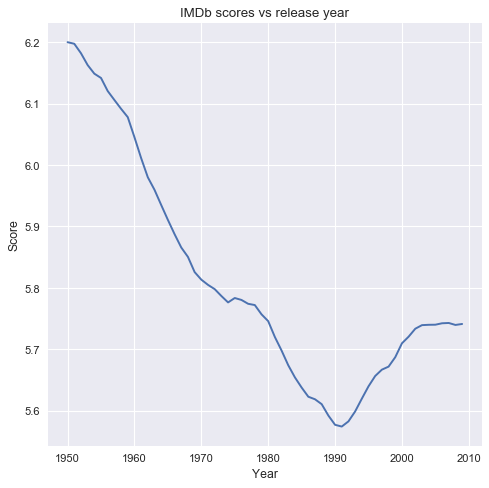

In [21]:
fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')

pop_y = movie_df.groupby(['Year'])['Score'].mean()
pop_y_slide_average = compute_sliding_averages(pd.Series(pop_y),5)
plt.plot(range(1950, 2010), pop_y_slide_average)
plt.xlabel("Year")
plt.ylabel("Score")
plt.title("IMDb scores vs release year")

plt.show()

From the plot, we observed that there is a significant drop around the 1980s. Is the trend also evident in other metrics?
Below is a plot of Gross against years.

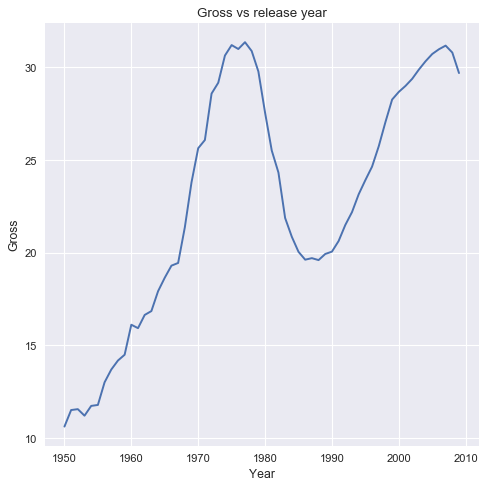

In [22]:
subdf = movie_df.dropna()
fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
gross_y = subdf.groupby(['Year'])['Gross'].mean()
gross_y_slide_average = compute_sliding_averages(pd.Series(gross_y),5)
plt.plot(range(1950, 2010), gross_y_slide_average)
plt.xlabel("Year")
plt.ylabel("Gross")
plt.title("Gross vs release year")
plt.show()

Not surprising, there is also a significant drop in the average gross over the decades as in the scores trend. This make us wonder: What can be the reason behind this drop? We presumed that it may be possible that the a lot more of movies were produced in the decade (i.e. a boom in the movie market), and the quality of movie decreased because of the lowered standard. We tried to plot the trend of the movie count of years.

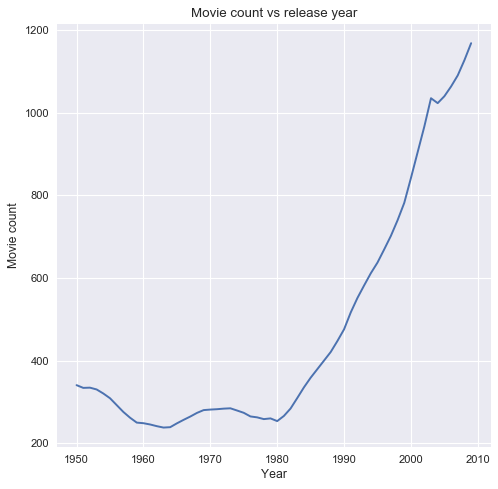

In [24]:
fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')

count_y = movie_df.groupby(['Year'])['Name'].count()
count_y_slide_average = compute_sliding_averages(pd.Series(count_y),5)
plt.plot(range(1950, 2010), count_y_slide_average)
plt.xlabel("Year")
plt.ylabel("Movie count")
plt.title("Movie count vs release year")

plt.show()

From the plot above, it is clear that the count of movie produced a year started to drastically increase at around 1980s. This trend supports our presumption above. This is very interesting.

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#ax= sns.regplot(x=subdf["Popularity"], y = subdf["Gross"],lowess=True)
plt.scatter(movie_df["Gross"].values.reshape(-1, 1), movie_df["Popularity"])
plt.xlabel("Gross")
plt.ylabel("Score")
plt.show()

In [ ]:
from regressors import stats
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=True, normalize=False)  
subdf = movie_df.dropna()
X = np.asarray(subdf["Gross"]).reshape(-1,1)
y = np.asarray(subdf["Popularity"])
lm.fit(X, y)
print(lm.coef_)
print(stats.coef_pval(lm, X, y))
stats.summary(lm, X, y)

In [ ]:
lm = LinearRegression(fit_intercept=True, normalize=False)  
generes = subdf.columns[5:]

subdf["Year"] = subdf["Year"] - 1940
X1 = np.asarray(subdf.iloc[:,[2]+list(range(6,subdf.shape[1] - 2))+ [4]], dtype='float')
y1 = np.asarray(subdf["Popularity"], dtype='float')
lm.fit(X1, y1)

coefs = lm.coef_
pvals = stats.coef_pval(lm, X1, y1)
stats.summary(lm, X1, y1)

In [ ]:
variable_names = [subdf.columns[2]]+ list(subdf.columns[6:subdf.shape[1] - 2]) + ["Gross"]
zipped = list(zip(variable_names, coefs, pvals[1:]))
important_factors = [ (name, coef, pval) for (name, coef, pval) in zipped ]
variable_names = ["Year"]+list(map(lambda x: x.split("_")[1], variable_names[1:-1]))+["Gross"]
# important_factors = [ (name, coef, pval) for (name, coef, pval) in zipped if pval < 0.05]
# ddd = pd.DataFrame(factors =variable_names, beta = coefs, pvalue = pvalue)
ddd = pd.DataFrame({'variable': variable_names,
     'beta': coefs,
     'p-value': pvals[1:]
    })
# important_factors
ddd[ddd["p-value"]<=0.05]

# EDITED
## What users can get from the summaries?

When people are comparing to pick the movies they want to see, people take the summaries of films into account besides the quantitative factors we investigated. So we intend to do an analysis on the movie summaries so that the users can have an idea of the movie quality from the description.
We chose to train a __naive bayes classifier__ from the summaries and report the most informative word features.
First, we assigned the tags to the films. Movies with less than 4 points will be poorly scored movies and movies with a score higher than 7 will be highly scored. Labeling like this gives us about the same number of documents in the poorly rated  pool and the highly rated pool.

In [85]:
# this code is adapted from https://pythonprogramming.net/words-as-features-nltk-tutorial/?completed=/text-classification-nltk-tutorial/
import nltk, re
from collections import Counter
from nltk.tokenize import word_tokenize
import random
random.seed(10)
# labeling function
def assign_label(x):
    if x < 4:
        return "poorly"
    if x < 7:
        return np.nan
    return "highly"

# get the label
ind = movie_df['Score'].apply(assign_label)
df_text = movie_df
df_text['ind'] = ind.values
df_text = df_text.drop("Gross", axis = 1)
df_text = df_text.dropna()

res = []

# helper function that tokenize the text into a word list
def to_list(w):
    w = re.sub(r'[^\w\s]','',w)
    return word_tokenize(w.lower())

documents = list(zip(df_text.Summary.apply(to_list), df_text.ind))
random.shuffle(documents)

# get the word features
all_words = list(filter(lambda x: len(x) >1, word_tokenize(re.sub(r'[^\w\s]'," "," ".join(df_text["Summary"])).lower())))
all_words = nltk.FreqDist(all_words)
word_features = [ w for (w,c) in list(all_words.most_common(1000)) if w != "ii"]

# convert a document into a feature set
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

# create the feature sets
featuresets = [(find_features(rev), category) for (rev, category) in documents]
training_set = featuresets[:3000]

# train the classifier 
classifier = nltk.NaiveBayesClassifier.train(training_set)

Before looking at the most informative features, we can check the accuracy of the classifier.

In [90]:
testing_set = featuresets[3000:]
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

Classifier accuracy percent: 73.87862796833772


Although the accuracy is not particularly strong, given the sample size it is pretty good.
Lets see what features it gives us.

In [91]:
classifier.show_most_informative_features(20)

Most Informative Features
                  weapon = True           poorly : highly =     13.9 : 1.0
                    hunt = True           poorly : highly =     12.9 : 1.0
                  aliens = True           poorly : highly =     12.9 : 1.0
                 british = True           highly : poorly =     11.8 : 1.0
              terrorized = True           poorly : highly =     11.0 : 1.0
                 zombies = True           poorly : highly =     10.6 : 1.0
                  crazed = True           poorly : highly =     10.0 : 1.0
                    hell = True           poorly : highly =     10.0 : 1.0
                  jewish = True           highly : poorly =      9.5 : 1.0
                 turning = True           poorly : highly =      9.1 : 1.0
              expedition = True           poorly : highly =      9.1 : 1.0
                   widow = True           highly : poorly =      9.1 : 1.0
                    know = True           poorly : highly =      8.9 : 1.0

From the most informative features we can see the films related to "british", "jewish", "widow", "determined", "london" are very likely to be a good movie and the ones related to supernatural forces and violence are likely to be poorly rated. the word "weapon" is 13.9 times more likely to occur in a movie with poor scores. This is interesting and aligns with our discovery of the score differences for genres.

# Conclusion

From this analysis, we can see that there is relationship between the movie scores and the film genre, release year, and gross.
This